+ https://medium.com/@xinyazhang08/how-to-use-tigramite-a-causality-package-20eca3ef1004
+ https://notebook.community/jakobrunge/tigramite/tutorials/tigramite_tutorial_basics
+ https://www.researchgate.net/figure/Constructing-a-causal-network-using-Tigramite-by-applying-PCMCI-to-time-series_fig2_369424272

In [27]:
import pandas as pd
import numpy as np
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

# magic command for module reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:

# Example time series data
np.random.seed(42)
time_series = np.random.randn(1000, 3)  # Simulated data: 1000 time points, 3 variables

# Initialize the data object for Tigramite
dataframe = pp.DataFrame(time_series, var_names=['var1', 'var2', 'var3'])

# Initialize PCMCI with tau_max set to 8
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=ParCorr(significance='analytic')
)

# Run PCMCI with tau_max=8
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)

# Initialize an empty list to store significant links
significant_links = []

# Print significant links
print("Significant links at p < 0.05:")
for i in range(results['p_matrix'].shape[0]):
    for j in range(results['p_matrix'].shape[1]):
        for tau in range(results['p_matrix'].shape[2]):
            if results['p_matrix'][i, j, tau] < 0.05:
                print(f"({dataframe.var_names[i]}, {dataframe.var_names[j]}, lag {tau-1})")
                # Store the significant link with variable names and lag
                significant_links.append((dataframe.var_names[j], dataframe.var_names[i], tau-1))



Significant links at p < 0.05:
(var2, var1, lag 2)
(var2, var3, lag 0)


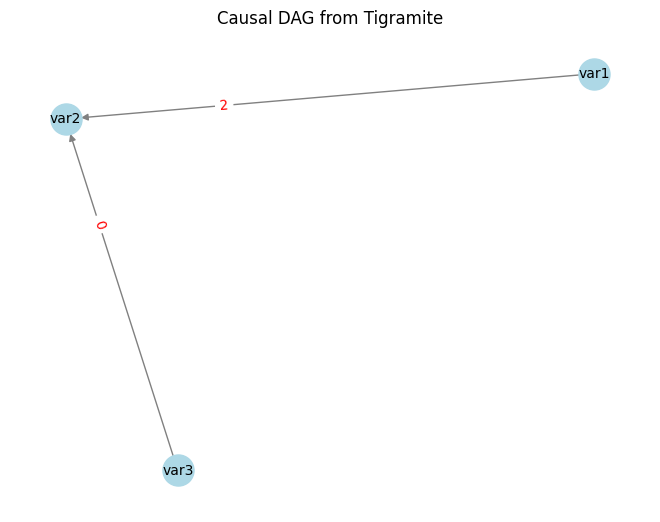

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each variable
for var_name in dataframe.var_names:
    G.add_node(var_name)

# Add edges for each significant link
for source, target, lag in significant_links:
    # Add an edge with the lag as a label
    G.add_edge(source, target, lag=lag)

# Draw the graph
pos = nx.spring_layout(G)  # Generate positions of nodes using spring layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)

# Add edge labels to show lags
edge_labels = dict(((u, v), d['lag']) for u, v, d in G.edges(data=True))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3, font_color='red')

plt.title("Causal DAG from Tigramite")
plt.show()




In [36]:
# fit a VAR model
from statsmodels.tsa.api import VAR
time_series_df = pd.DataFrame(time_series, columns=['var1', 'var2', 'var3'])
model = VAR(time_series_df)
results = model.fit(2)

# Get the lag order
lag_order = results.k_ar
print(f"Lag order: {lag_order}")

# Get the coefficients
coefficients = results.params
print(f"Coefficients:\n{coefficients}")

# Get the Granger causality matrix
granger_matrix = results.test_causality('var1', ['var2'], kind='f').summary()
print(f"Granger causality matrix:\n{granger_matrix}")

Lag order: 2
Coefficients:
             var1      var2      var3
const    0.050960 -0.006087  0.047500
L1.var1 -0.011304  0.007806  0.011647
L1.var2 -0.019876  0.020313 -0.094227
L1.var3 -0.016702  0.011821  0.037311
L2.var1  0.050278 -0.027879 -0.034435
L2.var2  0.021236 -0.013140  0.046455
L2.var3  0.014427  0.024120 -0.033211
Granger causality matrix:
Granger causality F-test. H_0: var2 does not Granger-cause var1. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.4418          2.999   0.643 (2, 2973)
-----------------------------------------------


In [43]:
# Let's make a better causal layout
# var3 is caused by lag1(var1) and lag2(var2)
# var2 is caused by lag0(var2)
var1 = np.random.randn(1000)
var2 = 3*var1 + np.random.randn(1000)

# Shift var1 and var2 without using pandas' shift
var1_shifted_1 = np.roll(var1, 1)
var2_shifted_2 = np.roll(var2, 2)

# Since roll wraps around, set the first 1 and 2 elements to 0 or NaN
var1_shifted_1[0] = np.nan
var2_shifted_2[:2] = np.nan

var3 = 2*var1_shifted_1 + 2*var2_shifted_2 + np.random.randn(1000)

time_series = np.array([var1, var2, var3]).T

df_time_series = pd.DataFrame(time_series, columns=['var1', 'var2', 'var3'])
pp_time_series = pp.DataFrame(df_time_series.dropna().values, var_names=['var1', 'var2', 'var3'])


In [45]:
df_time_series

,var1,var2,var3
0,-0.312567,0.216067,NaN
1,-0.522360,-1.498428,NaN
2,0.376367,2.068190,0.229484
3,0.386583,0.567634,-4.762954
4,0.950628,2.041967,4.906810
...,...,...,...
995,-1.250429,-2.920630,0.647688
996,-0.176407,-0.624371,-12.524819
997,0.353680,2.299322,-5.655845
998,-1.357632,-1.874060,-1.212756


In [44]:
# Initialize PCMCI with tau_max set to 8
pcmci = PCMCI(
    dataframe=pp_time_series, 
    cond_ind_test=ParCorr(significance='analytic')
)

# Run PCMCI with tau_max=8
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)

# Initialize an empty list to store significant links
significant_links = []

# Print significant links
print("Significant links at p < 0.05:")
for i in range(results['p_matrix'].shape[0]):
    for j in range(results['p_matrix'].shape[1]):
        for tau in range(results['p_matrix'].shape[2]):
            if results['p_matrix'][i, j, tau] < 0.05:
                print(f"({dataframe.var_names[i]}, {dataframe.var_names[j]}, lag {tau-1})")
                # Store the significant link with variable names and lag
                significant_links.append((dataframe.var_names[j], dataframe.var_names[i], tau-1))

Significant links at p < 0.05:
(var1, var2, lag -1)
(var1, var3, lag 0)
(var2, var1, lag -1)
(var2, var3, lag 1)


In [50]:
es_base0 = pd.read_csv('../../data/clean/BASE0_ES.csv', sep = ";", parse_dates=["Date"])
es_base0

,Date,reservas,CRM_messages,Destination_ads,Display_Segmentado,Festivos,GRP_Competencia,Google_Hotel,Google_PMAX,Google_Search_Brand,...,promocionupto15-offseason,promocionupto15-season,promocionupto20-season,promocionupto25-season,promocionupto30-season,promocionupto35-offseason,promocionupto40-offseason,rgi_metric,group,relative_ari_metric
0,2021-11-01,0.000000,357081.0,4570.0,319284.0,1.0,437.46,243228.0,0.000000,171637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.939613,1,0.011295
1,2021-11-08,0.000000,357081.0,3259.0,319284.0,0.0,774.75,282009.0,0.000000,184288.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.939613,1,0.011295
2,2021-11-15,0.000000,357081.0,2815.0,319284.0,0.0,605.71,265992.0,0.000000,188966.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.939613,1,0.011295
3,2021-11-22,0.000000,357081.0,3186.0,319284.0,0.0,318.09,281474.0,0.000000,178913.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.939613,1,0.011295
4,2021-11-29,0.000000,357081.0,4338.0,319284.0,0.0,87.29,308481.0,0.000000,158289.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.939613,1,0.011295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,2023-10-30,1575.083333,558783.0,4268.0,4725306.0,1.0,118.59,274230.0,4743.408666,127402.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.986718,12,0.014099
1304,2023-11-06,1652.904762,915236.0,4543.0,6712098.0,0.0,0.00,353533.0,4885.125344,138477.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.063813,12,0.060004
1305,2023-11-13,2004.728571,724777.0,3910.0,6256757.0,0.0,0.00,316352.0,5217.111259,142544.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.116057,12,0.051264
1306,2023-11-20,2005.547619,512060.0,4015.0,5991483.0,0.0,0.00,291874.0,7747.416855,150362.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.094101,12,0.026436


In [80]:
df_time_series = pd.concat(
    [
        es_base0[["Date", "group", "reservas"]].groupby(['Date']).sum().drop(['group'], axis=1),
        es_base0.loc[es_base0['group'] == 1, :].drop(["reservas", "group"], axis=1).set_index('Date'),
    ],
    axis=1
)

# Crete 'promos' column with the sum of all promotions
df_time_series['promos'] = df_time_series[[col for col in df_time_series.columns if 'promocion' in col]].sum(axis = 1)

cols_to_drop = ['gri_index', 'mpi_metric',
       'nps_index', 'promocionblackfriday', 'promociondiscovery_dollars',
       'promociondoublenights', 'promocionupto10-offseason',
       'promocionupto10-season', 'promocionupto15-offseason',
       'promocionupto15-season', 'promocionupto20-season',
       'promocionupto25-season', 'promocionupto30-season',
       'promocionupto35-offseason', 'promocionupto40-offseason', 'rgi_metric',
       'relative_ari_metric']

df_time_series = df_time_series.drop(cols_to_drop, axis = 1).dropna()

df_time_series

,reservas,CRM_messages,Destination_ads,Display_Segmentado,Festivos,GRP_Competencia,Google_Hotel,Google_PMAX,Google_Search_Brand,Google_Search_Hybrid,...,OTA_Travel_ads,Offline_competencia,Offline_propio,Prospecting,Retargeting,Seatback_cabeceros,TikTok,Youtube,ari_metric,promos
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-01,14282.434554,357081.0,4570.0,319284.0,1.0,437.46,243228.0,0.000000,171637.0,29962.0,...,7876.335294,1156875.92,10888.60,998249.0,329822.0,0.0,0.0,0.0,1.011295,0.0
2021-11-08,14932.532655,357081.0,3259.0,319284.0,0.0,774.75,282009.0,0.000000,184288.0,33713.0,...,7876.335294,1003222.55,0.00,998249.0,329822.0,0.0,0.0,0.0,1.011295,2.0
2021-11-15,13937.971212,357081.0,2815.0,319284.0,0.0,605.71,265992.0,0.000000,188966.0,35726.0,...,7876.335294,734865.86,0.00,998249.0,329822.0,0.0,0.0,0.0,1.011295,3.0
2021-11-22,13633.688961,357081.0,3186.0,319284.0,0.0,318.09,281474.0,0.000000,178913.0,30036.0,...,7876.335294,1052742.23,5930.46,998249.0,329822.0,0.0,0.0,0.0,1.011295,3.0
2021-11-29,12161.863320,357081.0,4338.0,319284.0,0.0,87.29,308481.0,0.000000,158289.0,24600.0,...,7876.335294,1296616.43,8409.60,998249.0,329822.0,0.0,0.0,0.0,1.011295,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-30,13920.191538,558783.0,4268.0,4725306.0,1.0,118.59,274230.0,4743.408666,127402.0,59617.0,...,62661.599206,166892.21,0.00,24103834.0,289717.0,118.0,0.0,0.0,1.014099,5.0
2023-11-06,13938.252753,915236.0,4543.0,6712098.0,0.0,0.00,353533.0,4885.125344,138477.0,54088.0,...,77257.711235,0.00,0.00,24278665.0,254245.0,100.0,876768.0,0.0,1.060004,6.0
2023-11-13,14728.721429,724777.0,3910.0,6256757.0,0.0,0.00,316352.0,5217.111259,142544.0,43247.0,...,64855.210383,0.00,0.00,21825980.0,428886.0,97.0,899239.0,0.0,1.051264,7.0


In [99]:
df_time_series.columns

Index(['reservas', 'CRM_messages', 'Destination_ads', 'Display_Segmentado',
       'Festivos', 'GRP_Competencia', 'Google_Hotel', 'Google_PMAX',
       'Google_Search_Brand', 'Google_Search_Hybrid', 'Google_Search_No_Brand',
       'Meta_branding', 'Meta_performance', 'Metabuscadores', 'OTA_Travel_ads',
       'Offline_competencia', 'Offline_propio', 'Prospecting', 'Retargeting',
       'Seatback_cabeceros', 'TikTok', 'Youtube', 'ari_metric', 'promos'],
      dtype='object')

In [ ]:
pp_time_series = pp.DataFrame(df_time_series.to_numpy(), var_names=df_time_series.columns)

c:\Users\migue\Documents\PROYECTOS DATA SCIENCE\causal_discovery\.venv\lib\site-packages\tigramite\plotting.py:391: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  pyplot.tight_layout()


(<Figure size 640x480 with 24 Axes>,
 array([<Axes: ylabel='reservas'>, <Axes: ylabel='CRM_messages'>,
        <Axes: ylabel='Destination_ads'>,
        <Axes: ylabel='Display_Segmentado'>, <Axes: ylabel='Festivos'>,
        <Axes: ylabel='GRP_Competencia'>, <Axes: ylabel='Google_Hotel'>,
        <Axes: ylabel='Google_PMAX'>, <Axes: ylabel='Google_Search_Brand'>,
        <Axes: ylabel='Google_Search_Hybrid'>,
        <Axes: ylabel='Google_Search_No_Brand'>,
        <Axes: ylabel='Meta_branding'>, <Axes: ylabel='Meta_performance'>,
        <Axes: ylabel='Metabuscadores'>, <Axes: ylabel='OTA_Travel_ads'>,
        <Axes: ylabel='Offline_competencia'>,
        <Axes: ylabel='Offline_propio'>, <Axes: ylabel='Prospecting'>,
        <Axes: ylabel='Retargeting'>, <Axes: ylabel='Seatback_cabeceros'>,
        <Axes: ylabel='TikTok'>, <Axes: ylabel='Youtube'>,
        <Axes: ylabel='ari_metric'>, <Axes: ylabel='promos'>], dtype=object))

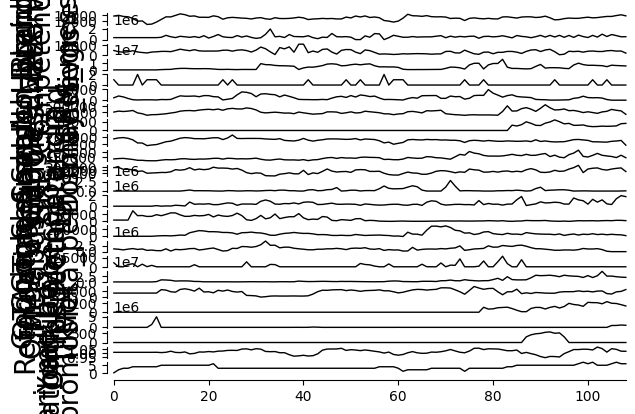

In [90]:
tp.plot_timeseries(pp_time_series, label_fontsize=20, tick_label_size=10);

In [81]:
# Initialize PCMCI with tau_max set to 8
pcmci = PCMCI(
    dataframe=pp_time_series, 
    cond_ind_test=ParCorr(significance='analytic')
)

# Run PCMCI with tau_max=8
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)

# Initialize an empty list to store significant links
significant_links = []

# Print significant links
print("Significant links at p < 0.05:")
for i in range(results['p_matrix'].shape[0]):
    # print(f"\n{pp_time_series.var_names[i]} - ")
    for j in range(results['p_matrix'].shape[1]):
        # print(f"{pp_time_series.var_names[j]} ")
        for tau in range(results['p_matrix'].shape[2]):
            if results['p_matrix'][i, j, tau] < 0.05:
                print(f"({pp_time_series.var_names[i]}, {pp_time_series.var_names[j]}, lag {tau-1})")
                # Store the significant link with variable names and lag
                significant_links.append((pp_time_series.var_names[j], pp_time_series.var_names[i], tau-1))

Significant links at p < 0.05:
(reservas, reservas, lag 0)
(reservas, reservas, lag 7)
(reservas, Display_Segmentado, lag 4)
(reservas, Festivos, lag -1)
(reservas, Festivos, lag 7)
(reservas, GRP_Competencia, lag 7)
(reservas, Google_Hotel, lag -1)
(reservas, Google_Search_Brand, lag -1)
(reservas, Google_Search_Brand, lag 2)
(reservas, Google_Search_Brand, lag 7)
(reservas, Google_Search_Hybrid, lag -1)
(reservas, Google_Search_No_Brand, lag -1)
(reservas, Google_Search_No_Brand, lag 1)
(reservas, Metabuscadores, lag -1)
(reservas, Metabuscadores, lag 7)
(reservas, OTA_Travel_ads, lag -1)
(reservas, Offline_competencia, lag 3)
(reservas, Offline_propio, lag 2)
(reservas, Prospecting, lag -1)
(reservas, Retargeting, lag 2)
(reservas, ari_metric, lag 3)
(CRM_messages, reservas, lag 5)
(CRM_messages, reservas, lag 6)
(CRM_messages, CRM_messages, lag 6)
(CRM_messages, Destination_ads, lag 6)
(CRM_messages, Google_PMAX, lag 3)
(CRM_messages, Google_Search_No_Brand, lag 0)
(CRM_messages, M

GPT
La salida del PCMCI te proporciona una lista de enlaces significativos entre diferentes variables a distintos retrasos (lags), lo que indica posibles relaciones causales en tus datos de series temporales. Aquí tienes una interpretación general basada en la estructura de tus resultados:

Relaciones Causales Directas: Cuando observas (X, Y, lag N), esto sugiere que la variable X podría causar Y con un retraso de N periodos de tiempo. Por ejemplo, (reservas, Display_Segmentado, lag 4) indica que las reservas en el tiempo t podrían estar causando un cambio en Display_Segmentado en el tiempo t+4.

Auto-Causalidad: Los enlaces como (X, X, lag N) indican autocorrelación o efectos auto-causales, donde el pasado de X influye en su futuro. Por ejemplo, (reservas, reservas, lag 7) sugiere que las reservas en un tiempo t están relacionadas con las reservas en el tiempo t+7, lo cual es común en series temporales que exhiben ciclicidad o tendencias estacionales.

Relaciones Causales entre Diferentes Variables: Los enlaces entre diferentes variables, especialmente con retrasos específicos, pueden ayudarte a identificar cómo se influyen mutuamente a lo largo del tiempo. Esto es especialmente útil para la planificación y la toma de decisiones. Por ejemplo, (CRM_messages, reservas, lag 5) indica que los mensajes de CRM podrían tener un impacto en las reservas 5 periodos de tiempo después.

Causas Primarias y Efectos Finales: Si ciertas variables solo aparecen como causas (solo tienen enlaces salientes) o como efectos (solo tienen enlaces entrantes), esto puede ayudarte a identificar variables que son causas primarias o efectos finales en tu sistema. Esto es crucial para entender la dinámica subyacente de tu sistema y para dirigir intervenciones efectivas.

Importancia de los Retrasos (Lags): El valor específico de los lags es crítico, ya que indica el tiempo que tarda el efecto de una variable en manifestarse en otra. Comprender esto es fundamental para la predicción y para planificar intervenciones temporales adecuadas.

En resumen, la lista proporcionada por PCMCI te da una visión detallada de las relaciones causales potenciales en tus datos, destacando cómo variables específicas pueden influir en otras a lo largo del tiempo. Esta información es invaluable para comprender la estructura causal subyacente de tus datos, lo que permite realizar predicciones más precisas, diseñar mejores intervenciones y tomar decisiones informadas basadas en la comprensión de las dinámicas causales.

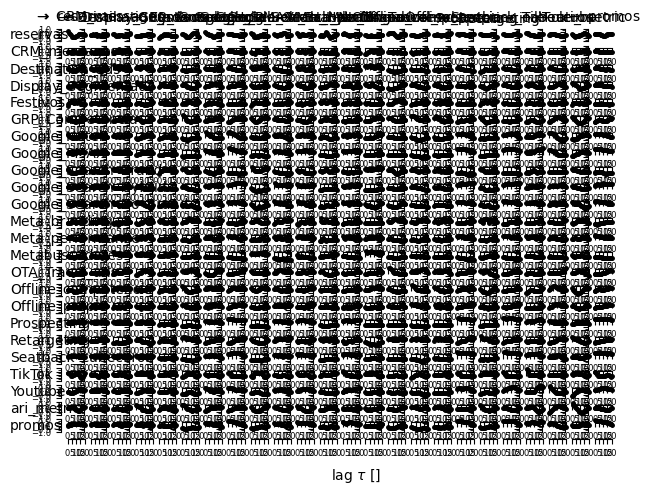

In [100]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']

lag_func_matrix = tp.plot_lagfuncs(
    val_matrix=correlations, 
    setup_args={'var_names':df_time_series.columns,
                'x_base':5, 
                'y_base':.5}
                );

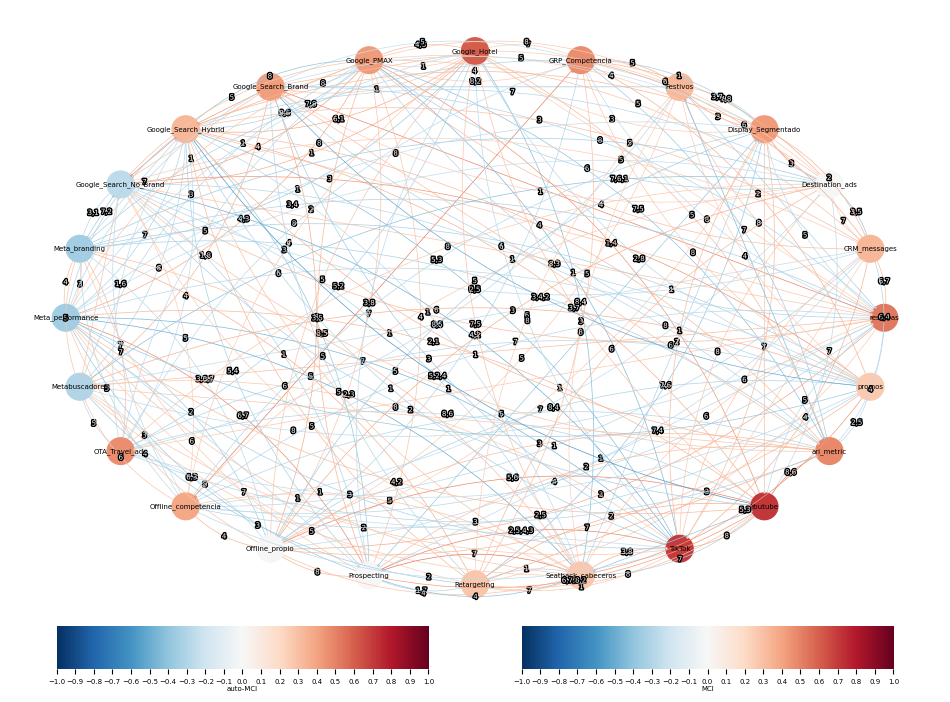

In [98]:
tp.plot_graph(
    figsize=(12, 8),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=df_time_series.columns,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    arrow_linewidth=0.5,
    arrowhead_size=2,
    link_label_fontsize=5,
    label_fontsize=5,
    tick_label_size=5,
    node_label_size=5,
    edge_ticks=0.1,
    node_ticks=0.1,
    node_size=0.1
    );

In [107]:
tp.plot_time_series_graph(
    figsize=(12, 8),
    val_matrix=results['val_matrix'],
    graph = results['graph'],
    var_names=df_time_series.columns,
    link_colorbar_label='MCI',
    label_fontsize=5,
    tick_label_size=5,
    arrow_linewidth=0.5,
    arrowhead_size=2,
    edge_ticks=0.1,
    node_size=0.05
);